In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import plotly.express as px
from scipy.signal import savgol_filter
import seaborn as sns
from tqdm import tqdm
from prophet import Prophet
import itertools
%matplotlib inline

# suppress pandas SettingWithCopyWarning 
pd.options.mode.chained_assignment = None

In [5]:
stock_df = pd.read_csv('C:\Stock-Recommendation\datasets\combined_file.csv')  
stock_df.info()
stock_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429926 entries, 0 to 429925
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date       429926 non-null  object 
 1   Ticker     429926 non-null  object 
 2   High       429926 non-null  float64
 3   Low        429926 non-null  float64
 4   Open       429926 non-null  float64
 5   Close      429926 non-null  float64
 6   Adj Close  429926 non-null  float64
 7   Volume     429926 non-null  float64
dtypes: float64(6), object(2)
memory usage: 26.2+ MB


,Date,Ticker,High,Low,Open,Close,Adj Close,Volume
0,2018-01-02,AAA,33.15,32.30,33.10,32.85,18.989,1563900.0
1,2018-01-03,AAA,33.15,32.50,33.00,32.95,19.046,1443310.0
2,2018-01-04,AAA,33.15,32.55,32.95,32.80,18.959,1533230.0
3,2018-01-05,AAA,33.00,32.40,32.80,32.60,18.843,1142150.0
4,2018-01-08,AAA,33.60,32.25,32.60,33.55,19.393,2204890.0


In [3]:
print(f"There are {stock_df['Ticker'].nunique()} stocks")

There are 287 stocks


In [4]:
stock_df['Date'] = pd.to_datetime(stock_df.Date)
print(f"Stocks start from {stock_df.Date.min()} to {stock_df.Date.max()}")

Stocks start from 2018-01-02 00:00:00 to 2023-12-29 00:00:00


In [5]:
total_days = (stock_df.Date.max() - stock_df.Date.min()).days + 1
dates_df = pd.DataFrame(pd.date_range(stock_df.Date.min(), periods=total_days, freq="D"), columns=['Date'])
display(dates_df.head(3))
display(dates_df.tail(3))

,Date
0,2018-01-02
1,2018-01-03
2,2018-01-04


,Date
2185,2023-12-27
2186,2023-12-28
2187,2023-12-29


Ở đây có 2187 ngày tuy nhiên thực tế chỉ có 1498 ngày do các ngày cuối tuần không giao dịch

In [6]:
def outlier_detection(stock_series_df):
    """
    Add column 'anomaly' to dataframe to mark outliers as True, non-outliers as False. 
    """
    # calculate interquartile range
    Q1 = stock_series_df['price_detrend'].quantile(0.25)
    Q3 = stock_series_df['price_detrend'].quantile(0.75)
    IQR = Q3 - Q1

    # identify outliers
    # Filtering Values between Q1-3IQR and Q3+3IQR
    stock_series_df['anomaly'] = (stock_series_df.price_detrend >= Q3 + 3*IQR) | (stock_series_df.price_detrend <= Q1 - 3*IQR)
    
    return stock_series_df

outlier_marked_list = []

for stock in stock_df.Ticker.unique():
        ticker_df = stock_df.loc[stock_df.Ticker==stock, :]
        # detrend sales for better detection of outliers
        ticker_df['price_detrend'] = signal.detrend(ticker_df['Close'].values)
        stock_outlier_marked_df = outlier_detection(ticker_df)
        outlier_marked_list.append(stock_outlier_marked_df)

outlier_marked_df = pd.concat(outlier_marked_list)

In [7]:
outlier_marked_df

,Date,Ticker,High,Low,Open,Close,Adj Close,Volume,price_detrend,anomaly
0,2018-01-02,AAA,33.15,32.30,33.10,32.85,18.989,1563900.0,12.975693,False
1,2018-01-03,AAA,33.15,32.50,33.00,32.95,19.046,1443310.0,13.082770,False
2,2018-01-04,AAA,33.15,32.55,32.95,32.80,18.959,1533230.0,12.939848,False
3,2018-01-05,AAA,33.00,32.40,32.80,32.60,18.843,1142150.0,12.746925,False
4,2018-01-08,AAA,33.60,32.25,32.60,33.55,19.393,2204890.0,13.704003,False
...,...,...,...,...,...,...,...,...,...,...
429921,2023-12-25,VTO,9.60,9.50,9.60,9.50,8.928,330800.0,-0.353516,False
429922,2023-12-26,VTO,9.58,9.45,9.50,9.50,8.928,138300.0,-0.355061,False
429923,2023-12-27,VTO,9.57,9.45,9.50,9.45,8.881,128900.0,-0.406606,False
429924,2023-12-28,VTO,9.51,9.38,9.45,9.49,8.919,182400.0,-0.368151,False


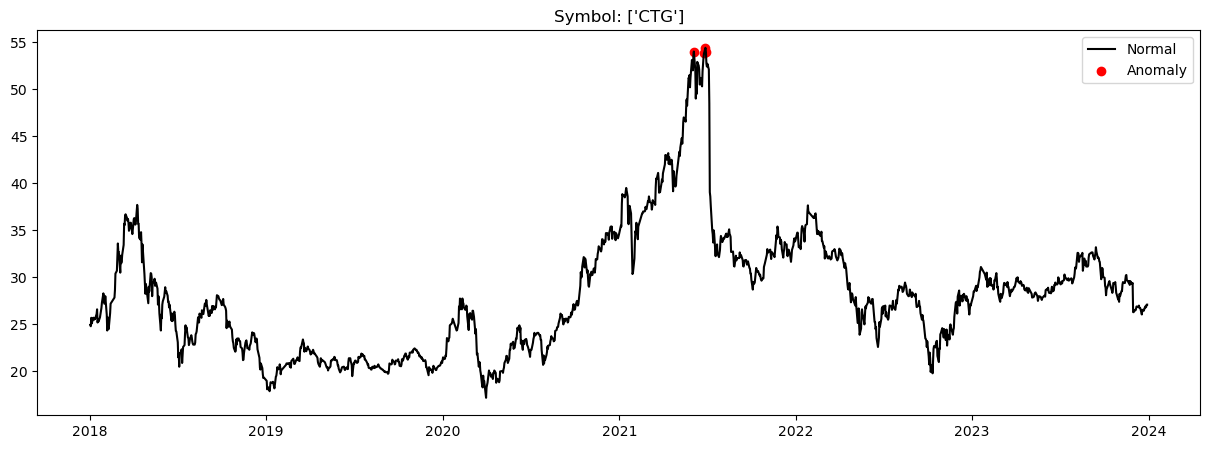

In [8]:
def visualize_outliers(symbol):
    outlier_series_df = outlier_marked_df.loc[outlier_marked_df.Ticker==symbol, :]
    # visualization of outliers detected
    fig, ax = plt.subplots(figsize=(15,5))
    a = outlier_series_df.loc[outlier_series_df['anomaly'] == 1, ['Date', 'Close']] #anomaly
    ax.plot(outlier_series_df.Date, outlier_series_df['Close'], color='black', label = 'Normal')
    ax.scatter(a.Date, a['Close'], color='red', label = 'Anomaly')
    plt.title(f'Symbol: {outlier_series_df.Ticker.unique()}')
    plt.legend()
    plt.show()

visualize_outliers('CTG')

In [9]:
print(f"Detected {outlier_marked_df.anomaly.sum()} outliers.")

Detected 3220 outliers.


In [10]:
outlier_marked_df.loc[outlier_marked_df['anomaly']==1, 'Close'] = np.nan

In [11]:
stock_imputed_df = outlier_marked_df.set_index(['Ticker', 'Date'])
stock_imputed_df.interpolate(inplace=True)
stock_imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 429926 entries, ('AAA', Timestamp('2018-01-02 00:00:00')) to ('VTO', Timestamp('2023-12-29 00:00:00'))
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   High           429926 non-null  float64
 1   Low            429926 non-null  float64
 2   Open           429926 non-null  float64
 3   Close          429926 non-null  float64
 4   Adj Close      429926 non-null  float64
 5   Volume         429926 non-null  float64
 6   price_detrend  429926 non-null  float64
 7   anomaly        429926 non-null  bool   
dtypes: bool(1), float64(7)
memory usage: 25.1+ MB


In [12]:
stock_imputed_df

High    Low   Open  Close  Adj Close     Volume  \
Ticker Date                                                           
AAA    2018-01-02  33.15  32.30  33.10  32.85     18.989  1563900.0   
       2018-01-03  33.15  32.50  33.00  32.95     19.046  1443310.0   
       2018-01-04  33.15  32.55  32.95  32.80     18.959  1533230.0   
       2018-01-05  33.00  32.40  32.80  32.60     18.843  1142150.0   
       2018-01-08  33.60  32.25  32.60  33.55     19.393  2204890.0   
...                  ...    ...    ...    ...        ...        ...   
VTO    2023-12-25   9.60   9.50   9.60   9.50      8.928   330800.0   
       2023-12-26   9.58   9.45   9.50   9.50      8.928   138300.0   
       2023-12-27   9.57   9.45   9.50   9.45      8.881   128900.0   
       2023-12-28   9.51   9.38   9.45   9.49      8.919   182400.0   
       2023-12-29   9.50   9.45   9.45   9.50      8.928    92100.0   

                   price_detrend  anomaly  
Ticker Date                                
AAA    2018-01-02      12.975693    False  
       2018-01-03      13.082770    False  
       2018-01-04      12.939848    False  
       2018-01-05      12.746925    False  
       2018-01-08      13.704003    False  
...                          ...      ...  
VTO    2023-12-25      -0.353516    False  
       2023-12-26      -0.355061    False  
       2023-12-27      -0.406606    False  
       2023-12-28      -0.368151    False  
       2023-12-29      -0.359695    False  

[429926 rows x 8 columns]

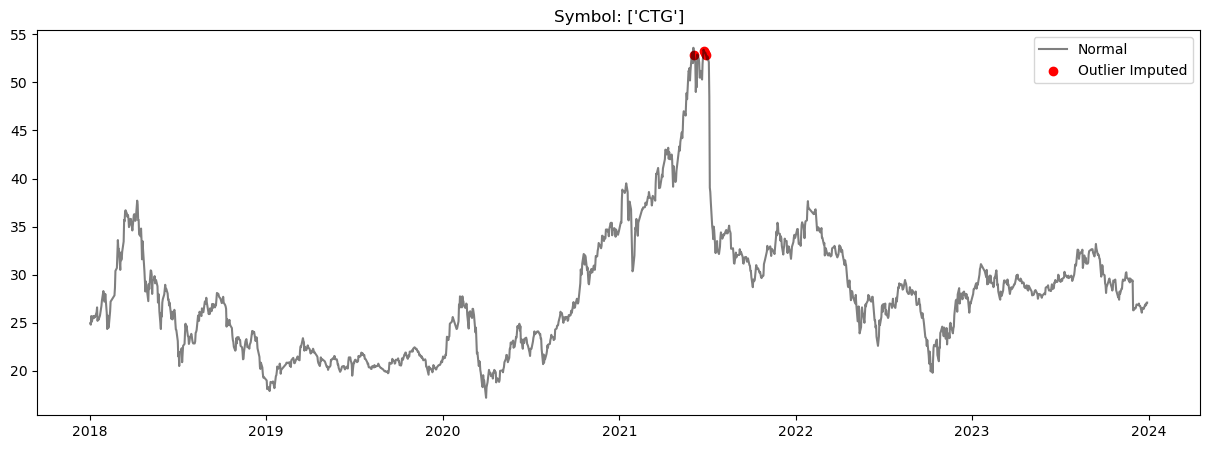

In [15]:
def visualize_sales(symbol):
    stock_series_df = stock_imputed_df.loc[stock_imputed_df.index.get_level_values('Ticker')==symbol, :]
    stock_series_df.reset_index(inplace=True)
    fig, ax = plt.subplots(figsize=(15,5))
    a = stock_series_df.loc[stock_series_df['anomaly'] == 1, ['Date', 'Close']] #anomaly
    ax.plot(stock_series_df.Date, stock_series_df['Close'], color='black', label = 'Normal', alpha=0.5)
    ax.scatter(a.Date, a['Close'], color='red', label = 'Outlier Imputed')
    plt.title(f'Symbol: {stock_series_df.Ticker.unique()}')
    plt.legend()
    plt.show()

visualize_sales('CTG')

In [16]:
stock_imputed_df.drop(columns=['price_detrend', 'anomaly']).to_csv('../datasets/price_processed.csv')

In [19]:
stock_df_processed = pd.read_csv('C:\Stock-Recommendation\datasets\price_processed.csv', parse_dates=['Date'])  
stock_df_processed.info()
stock_df_processed.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429926 entries, 0 to 429925
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Ticker     429926 non-null  object        
 1   Date       429926 non-null  datetime64[ns]
 2   High       429926 non-null  float64       
 3   Low        429926 non-null  float64       
 4   Open       429926 non-null  float64       
 5   Close      429926 non-null  float64       
 6   Adj Close  429926 non-null  float64       
 7   Volume     429926 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 26.2+ MB


,Ticker,Date,High,Low,Open,Close,Adj Close,Volume
0,AAA,2018-01-02,33.15,32.30,33.10,32.85,18.989,1563900.0
1,AAA,2018-01-03,33.15,32.50,33.00,32.95,19.046,1443310.0
2,AAA,2018-01-04,33.15,32.55,32.95,32.80,18.959,1533230.0
3,AAA,2018-01-05,33.00,32.40,32.80,32.60,18.843,1142150.0
4,AAA,2018-01-08,33.60,32.25,32.60,33.55,19.393,2204890.0


In [21]:
# filter for a time series
symbol = 'HPG'
stock_series_df_plot = stock_df_processed.loc[stock_df_processed.Ticker==symbol]

Text(0.5, 0, 'month')

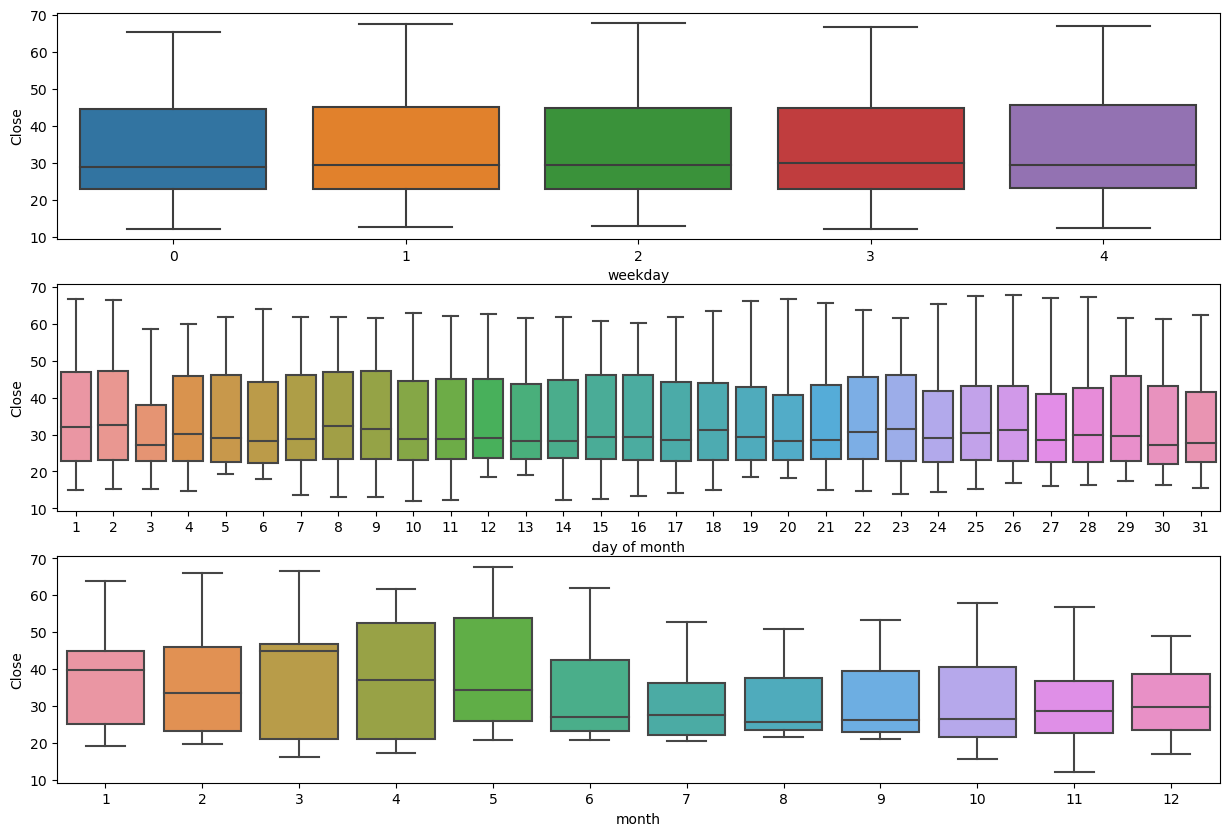

In [23]:
# box plots by weekday, day of month, and month
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
sns.boxplot(x=stock_series_df_plot.Date.dt.weekday, y=stock_series_df_plot.Close, ax=ax[0])
sns.boxplot(x=stock_series_df_plot.Date.dt.day, y=stock_series_df_plot.Close, ax=ax[1])
sns.boxplot(x=stock_series_df_plot.Date.dt.month, y=stock_series_df_plot.Close, ax=ax[2])

ax[0].set_xlabel('weekday')
ax[1].set_xlabel('day of month')
ax[2].set_xlabel('month')

C:\Users\Zbook G3\AppData\Local\Temp\ipykernel_88980\3129951126.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=stock_series_df_plot.Date.dt.weekday, y=stock_series_df_plot.Close, hue=stock_series_df_plot.Date.dt.year, ax=ax[0], ci=None)
C:\Users\Zbook G3\AppData\Local\Temp\ipykernel_88980\3129951126.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=stock_series_df_plot.Date.dt.day, y=stock_series_df_plot.Close, hue=stock_series_df_plot.Date.dt.year, ax=ax[1], ci=None)
C:\Users\Zbook G3\AppData\Local\Temp\ipykernel_88980\3129951126.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=stock_series_df_plot.Date.dt.month, y=stock_series_df_plot.Close, hue=stock_series_df_plot.Date.dt.year, ax=ax[2], ci=None)


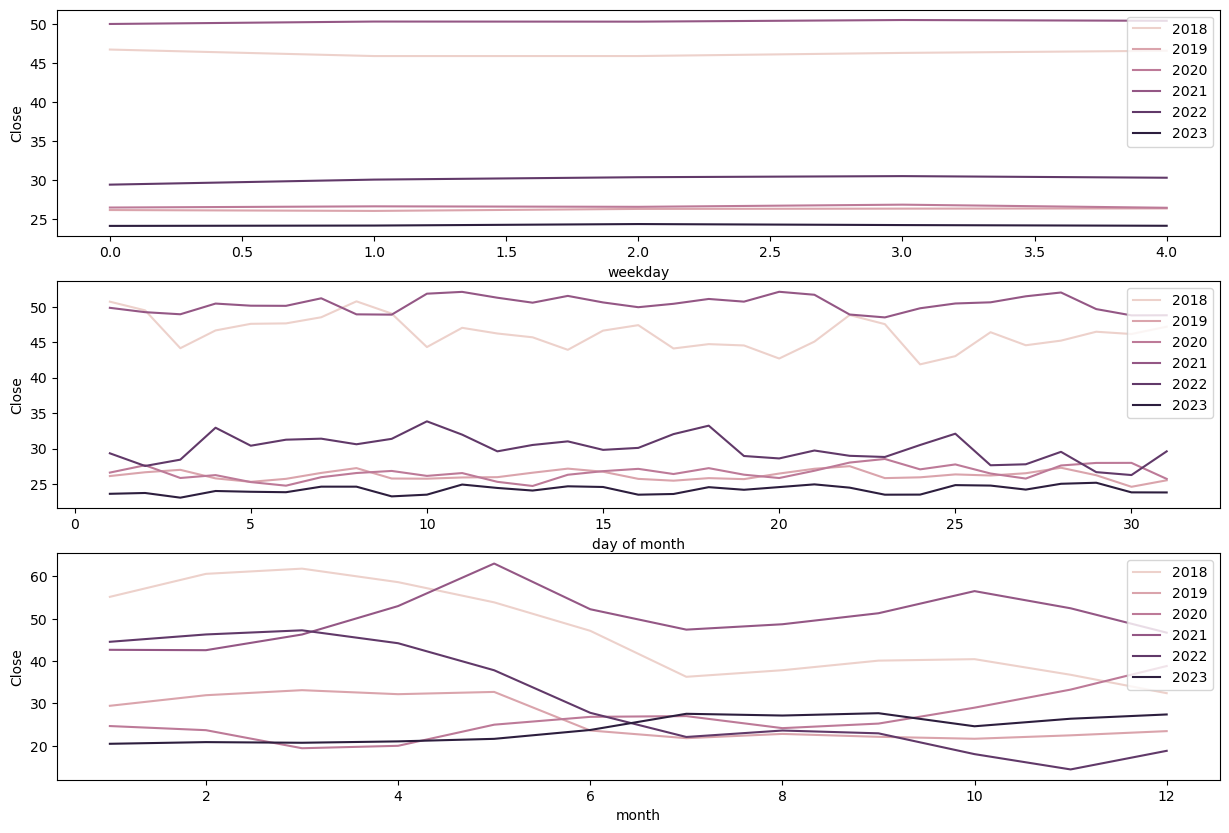

In [24]:
# line charts by weekday, day of month, and month, group by year
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,10))

sns.lineplot(x=stock_series_df_plot.Date.dt.weekday, y=stock_series_df_plot.Close, hue=stock_series_df_plot.Date.dt.year, ax=ax[0], ci=None)
sns.lineplot(x=stock_series_df_plot.Date.dt.day, y=stock_series_df_plot.Close, hue=stock_series_df_plot.Date.dt.year, ax=ax[1], ci=None)
sns.lineplot(x=stock_series_df_plot.Date.dt.month, y=stock_series_df_plot.Close, hue=stock_series_df_plot.Date.dt.year, ax=ax[2], ci=None)

ax[0].set_xlabel('weekday')
ax[1].set_xlabel('day of month')
ax[2].set_xlabel('month')

ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")
ax[2].legend(loc="upper right")

In [27]:
def get_cv_split(df, split_num, prediction_length=28, validation=True):
    """
    Implement train-test split given a cv split number and return training, val and test data
    """
    if 'series_id' not in df.columns:
        df['series_id'] = df['Ticker']

    series_list = df['Ticker'].unique()

    test_list = []
    validation_list = []
    training_list = []

    for series in series_list:
        df_series = df.loc[df.Ticker==series]
        max_date = df_series.Date.max()
        min_date = df_series.Date.min()
        test_lower_date = max_date - pd.Timedelta(f"{prediction_length*((split_num+1)*2-1)} days")
        test_upper_date = max_date - pd.Timedelta(f"{prediction_length*(split_num*2)} days")
        val_lower_date = max_date - pd.Timedelta(f"{prediction_length*(split_num+1)*2} days")
        if min(test_lower_date, test_upper_date) < min_date:
            raise Exception("Insufficient data for splitting")

        df_series_test = df_series.loc[(df_series.Date > test_lower_date) & (df_series.Date <= test_upper_date)]
        if validation:
            df_series_val = df_series.loc[(df_series.Date > val_lower_date) & (df_series.Date <= test_lower_date)]
            df_series_train = df_series.loc[df_series.Date <= val_lower_date]
        else:
            df_series_val = pd.DataFrame()
            df_series_train = df_series.loc[df_series.Date <= test_lower_date]
        test_list.append(df_series_test)
        validation_list.append(df_series_val)
        training_list.append(df_series_train)

    test_df = pd.concat(test_list)
    validation_df = pd.concat(validation_list)
    training_df = pd.concat(training_list)
    return training_df, validation_df, test_df

In [28]:
training_df, validation_df, test_df = get_cv_split(stock_df_processed, 0, validation=True)
print(f"Test data is from {test_df.Date.min()} to {test_df.Date.max()}")
print(f"Validation data is from {validation_df.Date.min()} to {validation_df.Date.max()}")
print(f"Training data is till {training_df.Date.max()}")

Test data is from 2023-12-04 00:00:00 to 2023-12-29 00:00:00
Validation data is from 2023-11-06 00:00:00 to 2023-12-01 00:00:00
Training data is till 2023-11-03 00:00:00


In [29]:
print(f"Test data consists of {len(test_df.loc[test_df.series_id=='HPG'])} days")
print(f"Validation data consists of {len(validation_df.loc[validation_df.series_id=='HPG'])} days")

Test data consists of 20 days
Validation data consists of 20 days


In [30]:
def naive_predictions(training_df, test_df):
    """
    Implement the Naive method and return dataframe with test data and corresponding predictions
    """
    series_list = training_df['series_id'].unique()
    naive_pred_list = []
    for series in series_list:
        training_df_series = training_df.loc[training_df.series_id==series]
        last_obs_df = training_df_series.loc[training_df_series.Date == training_df_series.Date.max(), ['series_id','Close']]
        naive_pred_list.append(last_obs_df)
    naive_pred_df = pd.concat(naive_pred_list)
    naive_pred_df.rename(columns={'Close':'naive_pred'}, inplace=True)
    naive_test_df = test_df.merge(naive_pred_df, on='series_id', how='left')
    return naive_test_df

In [31]:
training_df, _, test_df = get_cv_split(stock_df_processed, 0, validation=False)
naive_test_df = naive_predictions(training_df, test_df)
naive_test_df.info()
naive_test_df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5740 entries, 0 to 5739
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Ticker      5740 non-null   object        
 1   Date        5740 non-null   datetime64[ns]
 2   High        5740 non-null   float64       
 3   Low         5740 non-null   float64       
 4   Open        5740 non-null   float64       
 5   Close       5740 non-null   float64       
 6   Adj Close   5740 non-null   float64       
 7   Volume      5740 non-null   float64       
 8   series_id   5740 non-null   object        
 9   naive_pred  5740 non-null   float64       
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 493.3+ KB


,Ticker,Date,High,Low,Open,Close,Adj Close,Volume,series_id,naive_pred
0,AAA,2023-12-04,9.38,9.15,9.17,9.24,9.24,3368400.0,AAA,9.07
1,AAA,2023-12-05,9.37,9.26,9.37,9.34,9.34,2545400.0,AAA,9.07
2,AAA,2023-12-06,9.90,9.36,9.36,9.80,9.80,5637900.0,AAA,9.07


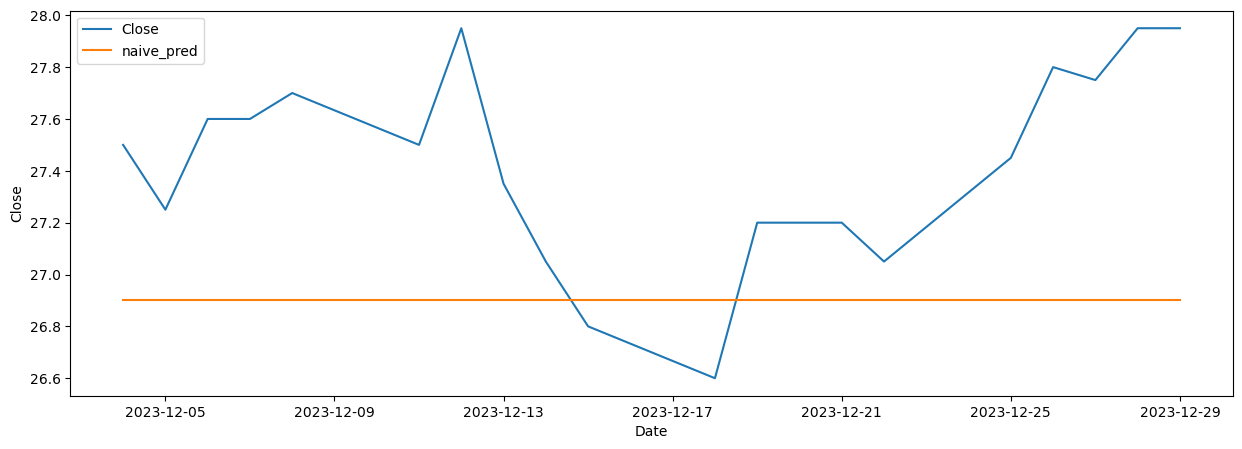

In [32]:
def plot_pred(prediction_test_df, series_id, yhat):
    """
    Plot the predictions against actual sales for a specified time series
    """
    prediction_test_df_series = prediction_test_df.loc[prediction_test_df.series_id==series_id]
    plt.figure(figsize=(15,5))
    sns.lineplot(x=prediction_test_df_series.Date, y=prediction_test_df_series.Close, label='Close')
    sns.lineplot(x=prediction_test_df_series.Date, y=prediction_test_df_series[yhat], label=yhat)

plot_pred(naive_test_df, 'HPG', 'naive_pred')

In [33]:
def snaive_predictions(training_df, test_df):
    """
    Implement the sNaive method and return dataframe with test data and corresponding predictions
    """
    training_df['dayofweek'] = training_df['Date'].dt.weekday
    series_list = training_df['series_id'].unique()
    snaive_pred_list = []
    for series in series_list:
        training_df_series = training_df.loc[training_df.series_id==series]
        training_df_series.sort_values(by='Date', ascending=False, inplace=True)
        last_week_df = training_df_series[:7][['dayofweek', 'series_id','Close']]
        snaive_pred_list.append(last_week_df)
    snaive_pred_df = pd.concat(snaive_pred_list)
    snaive_pred_df.rename(columns={'Close':'snaive_pred'}, inplace=True)
    test_df['dayofweek'] = test_df['Date'].dt.weekday
    snaive_test_df = test_df.merge(snaive_pred_df, on=['series_id', 'dayofweek'], how='left')
    return snaive_test_df

In [34]:
training_df, _, test_df = get_cv_split(stock_df_processed, 0, validation=False)
snaive_test_df = snaive_predictions(training_df, test_df)
snaive_test_df.info()
snaive_test_df.head(10)   

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8036 entries, 0 to 8035
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Ticker       8036 non-null   object        
 1   Date         8036 non-null   datetime64[ns]
 2   High         8036 non-null   float64       
 3   Low          8036 non-null   float64       
 4   Open         8036 non-null   float64       
 5   Close        8036 non-null   float64       
 6   Adj Close    8036 non-null   float64       
 7   Volume       8036 non-null   float64       
 8   series_id    8036 non-null   object        
 9   dayofweek    8036 non-null   int64         
 10  snaive_pred  8036 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(2)
memory usage: 753.4+ KB


,Ticker,Date,High,Low,Open,Close,Adj Close,Volume,series_id,dayofweek,snaive_pred
0,AAA,2023-12-04,9.38,9.15,9.17,9.24,9.24,3368400.0,AAA,0,9.03
1,AAA,2023-12-05,9.37,9.26,9.37,9.34,9.34,2545400.0,AAA,1,9.04
2,AAA,2023-12-06,9.90,9.36,9.36,9.80,9.80,5637900.0,AAA,2,9.09
3,AAA,2023-12-07,9.88,9.53,9.88,9.70,9.70,4177800.0,AAA,3,9.07
4,AAA,2023-12-07,9.88,9.53,9.88,9.70,9.70,4177800.0,AAA,3,9.05
5,AAA,2023-12-08,9.80,9.50,9.71,9.58,9.58,2541300.0,AAA,4,9.07
6,AAA,2023-12-08,9.80,9.50,9.71,9.58,9.58,2541300.0,AAA,4,9.07
7,AAA,2023-12-11,9.77,9.62,9.62,9.67,9.67,1423600.0,AAA,0,9.03
8,AAA,2023-12-12,9.79,9.62,9.79,9.65,9.65,1315700.0,AAA,1,9.04
9,AAA,2023-12-13,9.73,9.40,9.70,9.47,9.47,2381000.0,AAA,2,9.09


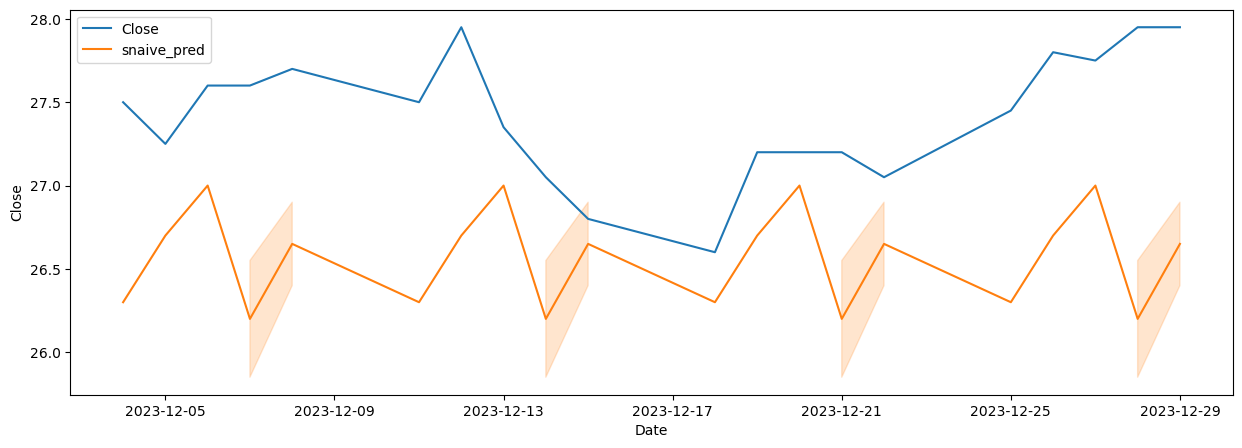

In [35]:
plot_pred(snaive_test_df, 'HPG', 'snaive_pred')

In [36]:
def compute_mae(training_df, prediction_test_df, y, y_hat, series_id):
    """
    Given a time series ID, compute the MAE for that time series and return the last 28-day training sales
    """
    prediction_test_df_series = prediction_test_df.loc[prediction_test_df.series_id==series_id]
    training_df_series = training_df.loc[training_df.series_id==series_id]
    training_df_series.sort_values(by='Date', ascending=False, inplace=True)
    prediction_test_df_series['abs_error'] = (prediction_test_df_series[y_hat] - prediction_test_df_series[y]).abs()
    mae = prediction_test_df_series['abs_error'].mean()
    total_sales = training_df_series[:28]['Close'].sum()
    return mae, total_sales

def compute_wmae(training_df, prediction_test_df, y, y_hat):
    """
    Given a training and prediction data, compute the weighted MAE
    """
    series_list = prediction_test_df.series_id.unique()
    sales_list = []
    mae_list = []
    for series in series_list:
        mae_series, total_sales_series = compute_mae(training_df, prediction_test_df, y, y_hat, series)
        mae_list.append(mae_series)
        sales_list.append(total_sales_series)
    overall_sales = np.sum(sales_list)
    weights_list = [s/overall_sales for s in sales_list]
    wmae_list = [a*b for a,b in zip(mae_list, weights_list)]
    wmae = np.sum(wmae_list)
    return wmae


In [38]:
wmae_list = []
cv = 3
for i in range(cv):
    training_df, _, test_df = get_cv_split(stock_df_processed, i, validation=False)
    naive_test_df = naive_predictions(training_df, test_df)
    wmae = compute_wmae(training_df, naive_test_df, 'Close', 'naive_pred')
    wmae_list.append(wmae)
print(f"The weighted MAE for each of the CV splits is : {wmae_list}")
print(f"The cross-validated weighted MAE is {np.mean(wmae_list)}")

The weighted MAE for each of the CV splits is : [1.5732435391118287, 2.1210523175192013, 1.8224670832146925]
The cross-validated weighted MAE is 1.8389209799485744


In [39]:
wmae_list = []
cv = 3
for i in range(cv):
    training_df, _, test_df = get_cv_split(stock_df_processed, i, validation=False)
    snaive_test_df = snaive_predictions(training_df, test_df)
    wmae = compute_wmae(training_df, snaive_test_df, 'Close', 'snaive_pred')
    wmae_list.append(wmae)
print(f"The weighted MAE for each of the CV splits is : {wmae_list}")
print(f"The cross-validated weighted MAE is {np.mean(wmae_list)}")

The weighted MAE for each of the CV splits is : [1.7753749588432126, 2.488512201095676, 2.009874469901404]
The cross-validated weighted MAE is 2.091253876613431


In [47]:
def prophet_predictions(training_df, test_df, cv, monthly_seasonality=True, changepoint_prior_scale=0.05, changepoint_range=0.8):
    """
    Train and predict sales using Prophet
    """
    training_df.rename(columns={'Close': 'y', 'Date':'ds'}, inplace=True)
    series_list = training_df['series_id'].unique()
    prophet_pred_list = []
    for series in tqdm(series_list, desc=f"Predicting for cv{cv}:"):
        training_df_series = training_df.loc[training_df.series_id==series]
        m = Prophet(yearly_seasonality=False, daily_seasonality=False, 
                    changepoint_prior_scale=changepoint_prior_scale, changepoint_range=changepoint_range)
        if monthly_seasonality:
            # add monthly seasonality to model
            m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        m.fit(training_df_series)
        future = m.make_future_dataframe(periods=28, include_history=False)
        forecast = m.predict(future)[['ds', 'yhat']]
        forecast['series_id'] = series
        prophet_pred_list.append(forecast)
    prophet_pred_df = pd.concat(prophet_pred_list)
    prophet_pred_df.rename(columns={'ds':'Date', 'yhat':'prophet_pred'}, inplace=True)
    prophet_test_df = test_df.merge(prophet_pred_df, on=['series_id', 'Date'], how='left')
    training_df.rename(columns={'ds': 'Date', 'y': 'Close'}, inplace=True)
    return m, prophet_test_df

In [48]:
cv = 0
training_df, validation_df, test_df = get_cv_split(stock_df_processed, cv, validation=True)
model, prophet_test_df = prophet_predictions(training_df, validation_df, cv)
prophet_test_df.info()
prophet_test_df.head(3)

Predicting for cv0::   0%|          | 0/287 [00:00<?, ?it/s]19:23:37 - cmdstanpy - INFO - Chain [1] start processing
19:23:38 - cmdstanpy - INFO - Chain [1] done processing
Predicting for cv0::   0%|          | 1/287 [00:01<05:11,  1.09s/it]19:23:38 - cmdstanpy - INFO - Chain [1] start processing
19:23:39 - cmdstanpy - INFO - Chain [1] done processing
Predicting for cv0::   1%|          | 2/287 [00:01<04:22,  1.09it/s]19:23:39 - cmdstanpy - INFO - Chain [1] start processing
19:23:40 - cmdstanpy - INFO - Chain [1] done processing
Predicting for cv0::   1%|          | 3/287 [00:02<04:16,  1.11it/s]19:23:40 - cmdstanpy - INFO - Chain [1] start processing
19:23:41 - cmdstanpy - INFO - Chain [1] done processing
Predicting for cv0::   1%|▏         | 4/287 [00:04<05:47,  1.23s/it]19:23:42 - cmdstanpy - INFO - Chain [1] start processing
19:23:42 - cmdstanpy - INFO - Chain [1] done processing
Predicting for cv0::   2%|▏         | 5/287 [00:05<05:28,  1.16s/it]19:23:43 - cmdstanpy - INFO - Chain

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5740 entries, 0 to 5739
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Ticker        5740 non-null   object        
 1   Date          5740 non-null   datetime64[ns]
 2   High          5740 non-null   float64       
 3   Low           5740 non-null   float64       
 4   Open          5740 non-null   float64       
 5   Close         5740 non-null   float64       
 6   Adj Close     5740 non-null   float64       
 7   Volume        5740 non-null   float64       
 8   series_id     5740 non-null   object        
 9   prophet_pred  5740 non-null   float64       
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 493.3+ KB


,Ticker,Date,High,Low,Open,Close,Adj Close,Volume,series_id,prophet_pred
0,AAA,2023-11-06,8.96,8.69,8.76,8.90,8.90,2780900.0,AAA,10.255374
1,AAA,2023-11-07,8.94,8.70,8.88,8.72,8.72,1921700.0,AAA,10.420475
2,AAA,2023-11-08,9.30,8.70,8.72,9.29,9.29,4512400.0,AAA,10.540161


In [45]:
prophet_test_df

,Ticker,Date,High,Low,Open,Close,Adj Close,Volume,series_id,prophet_pred
0,AAA,2023-11-06,8.96,8.69,8.76,8.90,8.900,2780900.0,AAA,10.255374
1,AAA,2023-11-07,8.94,8.70,8.88,8.72,8.720,1921700.0,AAA,10.420475
2,AAA,2023-11-08,9.30,8.70,8.72,9.29,9.290,4512400.0,AAA,10.540161
3,AAA,2023-11-09,9.40,9.20,9.30,9.21,9.210,3983000.0,AAA,10.519708
4,AAA,2023-11-10,9.27,9.07,9.12,9.10,9.100,2979600.0,AAA,10.379382
...,...,...,...,...,...,...,...,...,...,...
5735,VTO,2023-11-27,9.24,9.01,9.24,9.01,8.468,102100.0,VTO,9.850986
5736,VTO,2023-11-28,9.18,9.05,9.05,9.13,8.580,76300.0,VTO,9.888943
5737,VTO,2023-11-29,9.18,9.10,9.10,9.14,8.590,94400.0,VTO,9.985951
5738,VTO,2023-11-30,9.19,9.11,9.14,9.17,8.618,108800.0,VTO,10.030449


In [50]:
future_date = pd.DataFrame({'ds':['2024-09-25']})
model.predict(future_date)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-09-25,11.67132,10.882968,12.546715,11.67132,11.67132,0.012834,0.012834,0.012834,-0.018318,-0.018318,-0.018318,0.031152,0.031152,0.031152,0.0,0.0,0.0,11.684154


In [6]:
stock_df['Date'].max()

'2023-12-29'